# Set up

## Python path

In [1]:
from pathlib import Path
import sys

# Add the parent directory to the system path
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

## Packages

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix, build_design_matrices
import seaborn as sns
from sklearn.linear_model import LinearRegression

import const
from heart_model import HeartDiseaseModel
import utils

## Constants

## Set defaults

In [3]:
utils.set_default_plot_style()

## Functions

# Generate sample data

In [4]:
try:
    sample_data = pd.read_csv(const.SPLINE_SAMPLE_DATA_PATH)
    x = sample_data["x"].values
    y = sample_data["y"].values
except FileNotFoundError:
    # helpful little package for sample data
    %pip install regressio --upgrade
    from regressio.datagen import generate_random_walk

    x, y = generate_random_walk(200, plot=False)
    x /= x.max()
    sample_data = pd.DataFrame({"x": x, "y": y})
    sample_data.to_csv(const.SPLINE_SAMPLE_DATA_PATH, index=False)

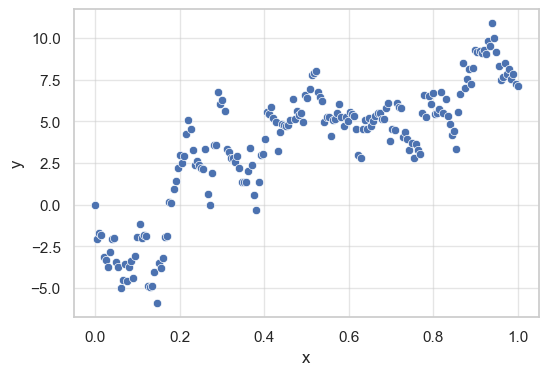

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(sample_data, x="x", y="y",ax=ax);

## Introduction to `patsy`

`patsy` is a package for describing statistical models and generating design matrices.
It is particularly useful for splines.

Before getting to splines it's worth getting used to the `patsy` syntax.

### Linear regression

We'll start by just doing linear regression: `y = ax +b`.

In [6]:
# design matrix for y ~ x + 1 (intercept is automatically added)
dmatrix("x", {"x": [1, 2, 3]})

DesignMatrix with shape (3, 2)
  Intercept  x
          1  1
          1  2
          1  3
  Terms:
    'Intercept' (column 0)
    'x' (column 1)

In [7]:
# can generate the y-value but this generally isn't necessary
y_, _ = dmatrices("y ~ x", {"x": [1, 2, 3], "y": [4, 5, 6]})
y_

DesignMatrix with shape (3, 1)
  y
  4
  5
  6
  Terms:
    'y' (column 0)

In [8]:
# we can remove the intercept by adding '-1'
dmatrix("x - 1", {"x": [1, 2, 3]})

DesignMatrix with shape (3, 1)
  x
  1
  2
  3
  Terms:
    'x' (column 0)

Once we have the design matrix we can fit a linear model in the usual way.

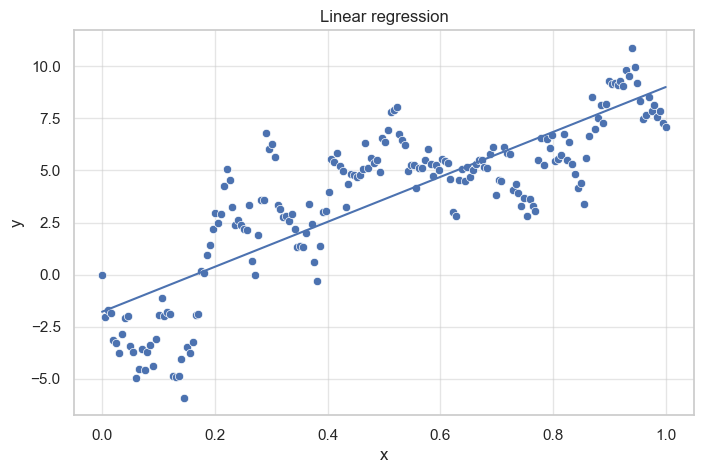

In [10]:
# in practice we input the data as a DataFrame (or Series)
X = dmatrix("x", sample_data)

# the intercept is already in the design matrix
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, sample_data.y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y",ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Linear regression");

To predict on new data we make a new design matrix based on information from the one we used for fitting.

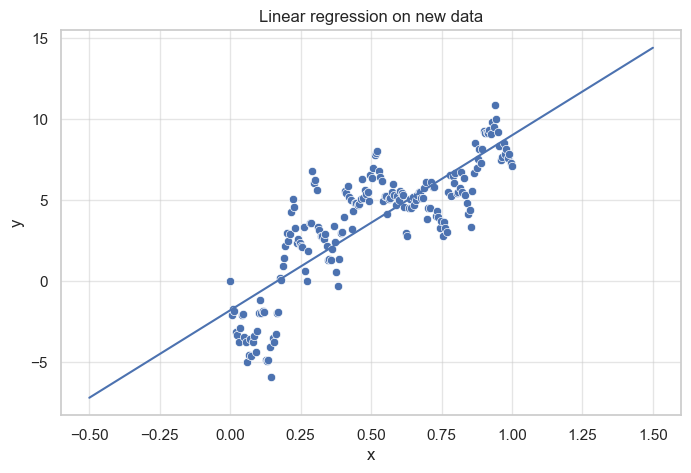

In [10]:
x_new = np.linspace(-0.5, 1.5, 100)
X_new = build_design_matrices([X.design_info], {"x": x_new})[0]

y_pred_new = lin_reg.predict(X_new)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y",ax=ax)
ax.plot(x_new, y_pred_new)
ax.set(title="Linear regression on new data");

### Categorical data

`patsy` handles categorical variables automatically.
By default it uses one-hot encoding.

In [ ]:
dmatrix("x_cat", {"x_cat": ["cat1", "cat2", "cat3"]})

DesignMatrix with shape (3, 3)
  Intercept  x[T.cat2]  x[T.cat3]
          1          0          0
          1          1          0
          1          0          1
  Terms:
    'Intercept' (column 0)
    'x' (columns 1:3)

Not that it automatically selects one category to remove.
If we remove the intercept it keeps the design matrix at full rank by keeping all categories:

In [11]:
dmatrix("x_cat - 1", {"x_cat": ["cat1", "cat2", "cat3"]})

DesignMatrix with shape (3, 3)
  x_cat[cat1]  x_cat[cat2]  x_cat[cat3]
            1            0            0
            0            1            0
            0            0            1
  Terms:
    'x_cat' (columns 0:3)

# 5.2 Piecewise Polynomials and Splines

## Splines

Suppose we have $K$ *knots* $\xi_1<\cdots \xi_K$.
An order-$M$ spline with knots $\xi_j$ is a piecewise polynomial of order $M$ on each interval $(-\infty, \xi_1), (\xi_1, \xi_2), \ldots (\xi_{K-1}, \xi_K), (\xi_K, \infty)$ with continuous derivatives up to order $M-2$ at each knot.

Note that order $M$ means degree $d=M-1$.
In practice we only ever use $M=2$, piecewise linear curves, or $M=4$, cubic splines.

A simple default for knot placement is to use quantiles of the data.

*Note:* It may be necessary to restrict to unique values before taking quantiles to avoid duplicate knots.

## Degrees of freedom

An order-$M$ spline consists of $K+1$ order $M$ polynomials, each contributing $M$ degrees of freedom.
The boundary conditions at the $K$ knots each remove $M-2$ degrees of freedom, so in total we have

\begin{equation}\tag{full rank splines}
    \text{df} = M + K.
\end{equation}

Note that this set of splines will be of full rank; that is, it includes an intercept.
If we build a model with splines for multiple features we need to reduce the degrees of freedom by 1 to avoid introducing redundency:

\begin{equation}\tag{no intercept splines}
    \text{df} = M + K - 1.
\end{equation}

## Spline bases

There are many equivalent splines bases.
The *$B$-spline* basis is efficient even for large $K$ so is often used.

The B-spline basis involves adding boundary knots outside the domain of your data- $M$ to the left and $M$ to the right.
So, when fitting cubic splines on data defined on [0, 1] we might add (interior) knots at 0.25, 0.5, and 0.75 and 4 boundary knots each at 0 and 1.
Some implementations (`patsy`) do this automatically but some (`scipy.interpolate.BSpline`) require you to specify the boundary knots.

### Splines in `patsy`

`patsy` is a convenient package for splines.
It takes care of generating the design matrices.
There is also an implementation in `scipy.interpolate.BSpline` but I find it less intuitive.
This allows extrapolation using the outer fitted polynomials, but this is probably a bad idea.

We fit cubic splines exactly as with Linear Regression, we just change the formula that goes into the design matrix.
By default, `patsy` takes quantiles of the data for the position of the knots, but this is configurable with the `knots` argument.
Note that this is quantiles *after removing duplicate x-values*. 

In [16]:
X = dmatrix("bs(x, df=7, degree=3, include_intercept=True) - 1", sample_data)
X

DesignMatrix with shape (200, 7)
  Columns:
    ['bs(x, df=7, degree=3, include_intercept=True)[0]',
     'bs(x, df=7, degree=3, include_intercept=True)[1]',
     'bs(x, df=7, degree=3, include_intercept=True)[2]',
     'bs(x, df=7, degree=3, include_intercept=True)[3]',
     'bs(x, df=7, degree=3, include_intercept=True)[4]',
     'bs(x, df=7, degree=3, include_intercept=True)[5]',
     'bs(x, df=7, degree=3, include_intercept=True)[6]']
  Terms:
    'bs(x, df=7, degree=3, include_intercept=True)' (columns 0:7)
  (to view full data, use np.asarray(this_obj))

Note the default is `include_intercept=False`, but setting it to `True` and removing the `Intercept` column makes the number of knots agree with our formulation above: $\text{df} = K + 4$.

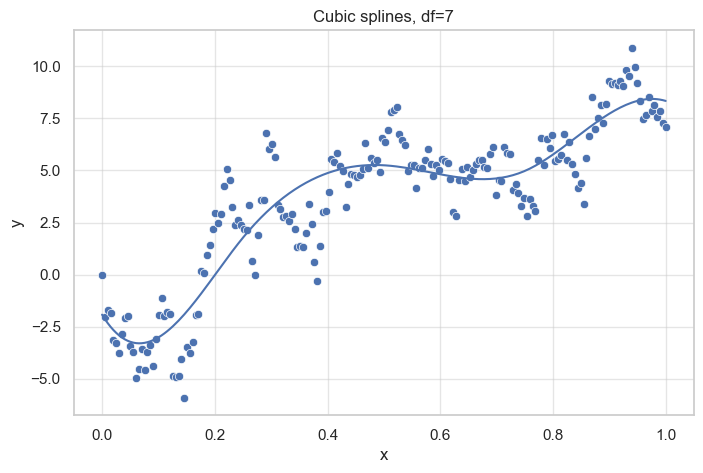

In [12]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y", ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Cubic splines, df=7");

We get the same result if we set `include_intercept=False` and keep the intercept in.
Note that we have to reduce the degrees of freedom by 1:

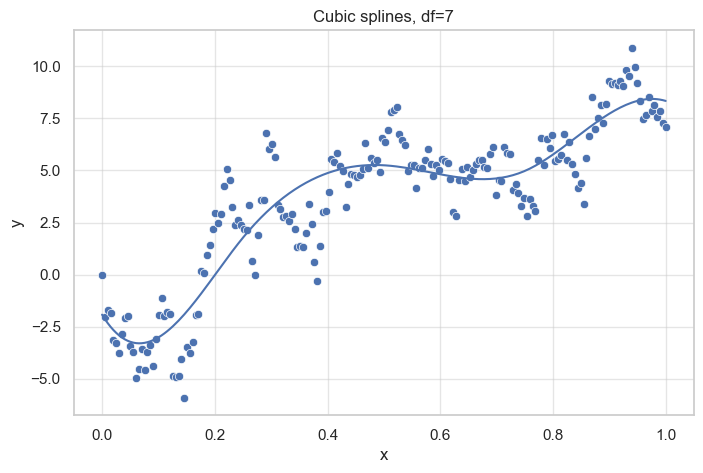

In [ ]:
X = dmatrix("bs(x, df=6, degree=3, include_intercept=False)", sample_data)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y", ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Cubic splines, df=7");

`patsy` uses B-spline bases.
We can visualise the individual basis functions.

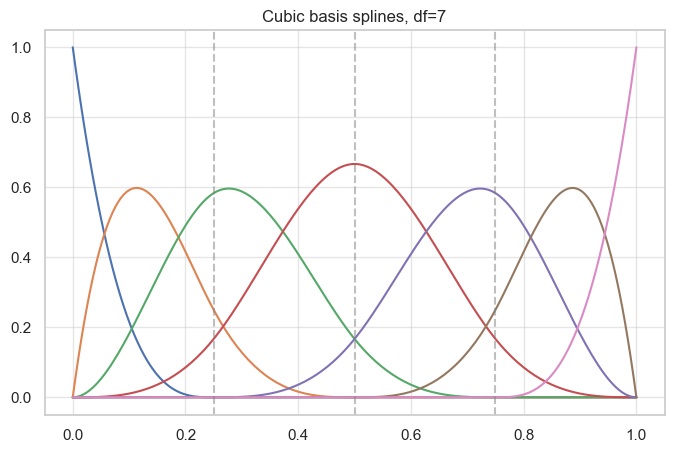

In [ ]:
X = dmatrix("bs(x, df=7, degree=3, include_intercept=True) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(7)
ax.plot(x, X*b)

# plot knot locations
n_knots = 7 - 4 # df = K + 4
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Cubic basis splines, df=7");

Removing the intercept is equivalent to forcing the splines to all be zero at the leftmost point:

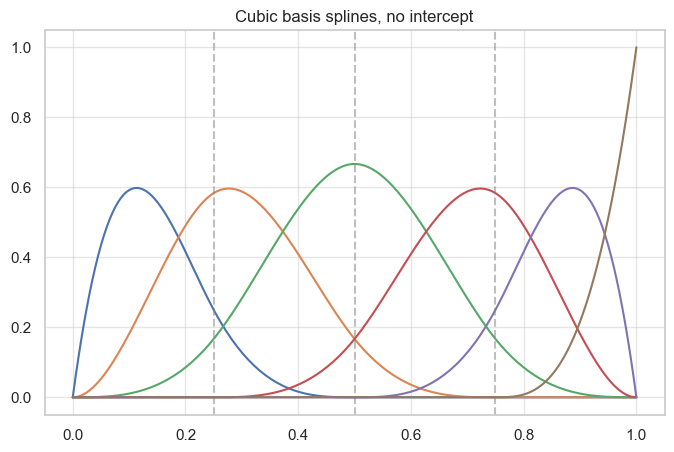

In [ ]:
X = dmatrix("bs(x, df=6, degree=3, include_intercept=False) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(6)
ax.plot(x, X*b)

# plot knot locations
n_knots = 6 - 3 # df = K + 4 - 1
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Cubic basis splines, no intercept");

We can see how changing the degrees of freedom affects the spline curve

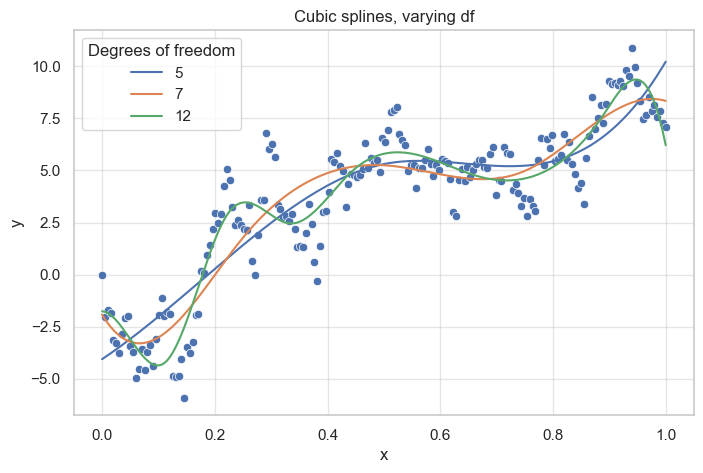

In [ ]:
degrees_of_freedom = [5, 7, 12]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

for df in degrees_of_freedom:
    X = dmatrix(f"bs(x, df={df}, degree=3, include_intercept=True) - 1", sample_data)

    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    y_pred = lin_reg.predict(X)

    ax.plot(sample_data.x, y_pred, label=str(df))

ax.set(title="Cubic splines, varying df")
ax.legend(title="Degrees of freedom");

## Natural cubic splines

The plot above suggests that cubic splines have high variance near the boundary.
We can reduce this by adding the additional constraint that the function is linear outside the boundary knots.
Such a spline is called a *natural cubic spline*.

These constraints remove two degrees of freedom as each end.
As a consequence we have:

\begin{equation}\tag{full rank natural cubic splines, no boundary knots}
    \text{df} = K.
\end{equation}

*Note:* There is some ambiguity around what we mean by 'outside the boundary knots'.
The construction in the chapter seems to take this to mean $\xi_1$ and $\xi_K$, but in the definition of B-splines at the end of the chapter we add additional knots $\xi_0$ and $\xi_{K+1}$ which are described as 'boundary knots'.
The question is whether we constrain the function to be linear outside the bounds of the data or if that restriction starts within the data range.

If we do add two boundary knots then we get back two degrees of freedom:

\begin{equation}\tag{full rank natural cubic splines, with boundary knots}
    \text{df} = K + 2.
\end{equation}


### In `patsy`

`patsy` has an implementation of natural cubic splines using a modification of B-splines as a basis.
By default it adds the minimum and maximum of the data as boundary knots and enforces the linearity outside those bounds.
These boundary knots can be changed using the `lower_bound` and `upper_bound` arguments.
As a consequence the degreees of freedom formula is:

\begin{equation}\tag{full rank cr in patsy}
    \text{df} = K + 2.
\end{equation}

We can compare cubic splines and natural cubic splines with the same number of degrees of freedom.
The regular cubic splines can't extrapolate, but the natural splines are able to extrapolate linearly.

In [22]:
def fit_predict_from_dmatrix(X, y, x_pred):
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    X_pred = build_design_matrices([X.design_info], {"x": x_pred})[0]
    return lin_reg.predict(X_pred)

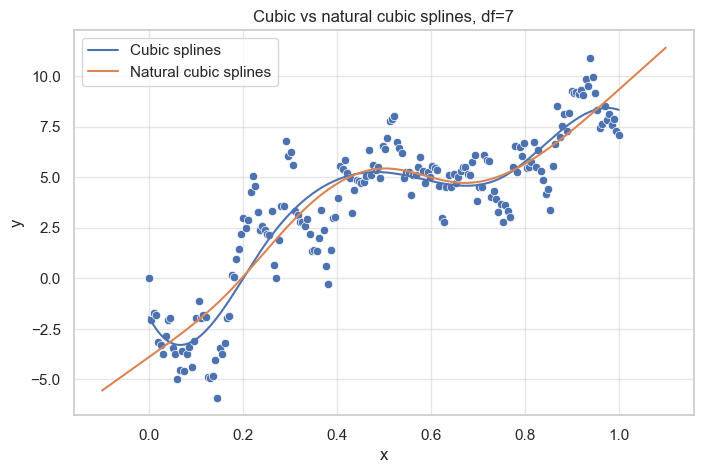

In [ ]:
X = dmatrix("bs(x, df=7,  degree=3, include_intercept=True) - 1", sample_data)
X_nat = dmatrix("cr(x, df=7) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

x_pred = x # cubic splines are only defined within the range of the data
y_pred = fit_predict_from_dmatrix(X, y, x_pred)
ax.plot(x_pred, y_pred, label="Cubic splines")

# extend to show extrapolation
x_pred = np.linspace(-0.1, 1.1, 200)
y_nat_pred = fit_predict_from_dmatrix(X_nat, y, x_pred)
ax.plot(x_pred, y_nat_pred, label="Natural cubic splines")


ax.set(title="Cubic vs natural cubic splines, df=7")
ax.legend();

Note how the natural cubic splines are regularised near the boundary.

By default natural cubic splines in `patsy` are full rank - they include an intercept term.
We can remove this by adding a constraint.
The constraint itself doesn't matter - `[1, 0, .., 0]` will force the splines to all be zero at the lower bound, `'center'` is fine as a default.
Of course this will reduce the degrees of freedom by 1:

\begin{equation}\tag{no intercept cr in patsy}
    \text{df} = K + 1.
\end{equation}

Let's see how naturality has affected the basis functions - note that we get a lot more knots:

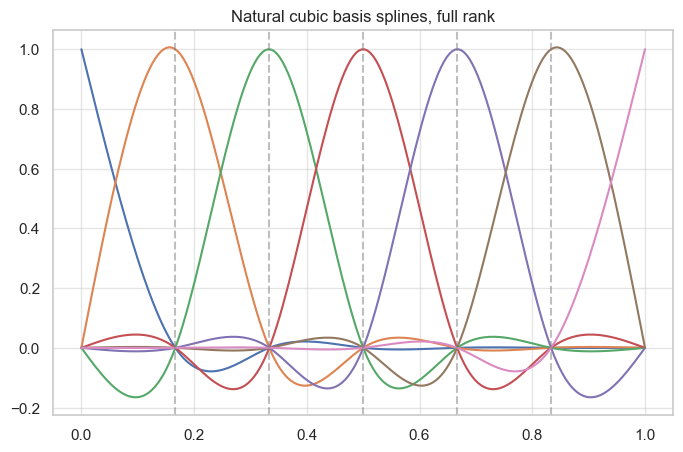

In [48]:
X_nat = dmatrix(f"cr(x, df=7) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(7)
ax.plot(x, X_nat*b)

# plot (inner) knot locations
n_knots = 5  # df = K + 2
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Natural cubic basis splines, full rank");

With centering constraints:

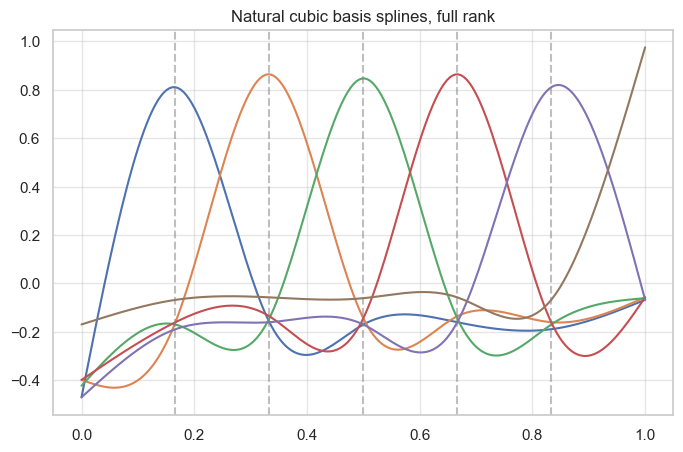

In [49]:
X_nat = dmatrix(f"cr(x, df=6, constraints='center') - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(6)
ax.plot(x, X_nat*b)

# plot (inner) knot locations
n_knots = 5  # df = K + 1
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Natural cubic basis splines, full rank");

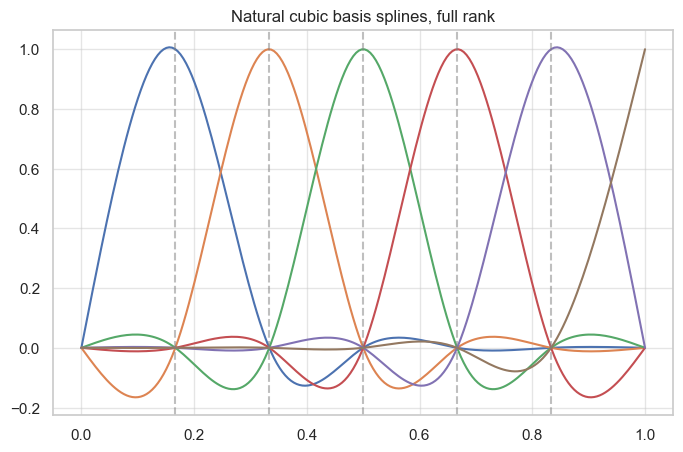

In [52]:
X_nat = dmatrix(f"cr(x, df=6, constraints=[1, 0, 0, 0, 0, 0, 0]) - 1", sample_data)

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(6)
ax.plot(x, X_nat*b)

# plot (inner) knot locations
n_knots = 5  # df = K + 1
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Natural cubic basis splines, full rank");

## 5.2.2 Example: South African Heart Disease

I want to recreate this example from the book.
The implementation can be found in `heart_model.py`.

In [55]:
heart_data = pd.read_csv(const.SOUTH_AFRICAN_HEART_DISEASE_DATA_PATH, index_col=0)

I'll just use the features they found rather then implementing backwards selection

/Users/c.leonard/P/elements-of-statistical-learning/env/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


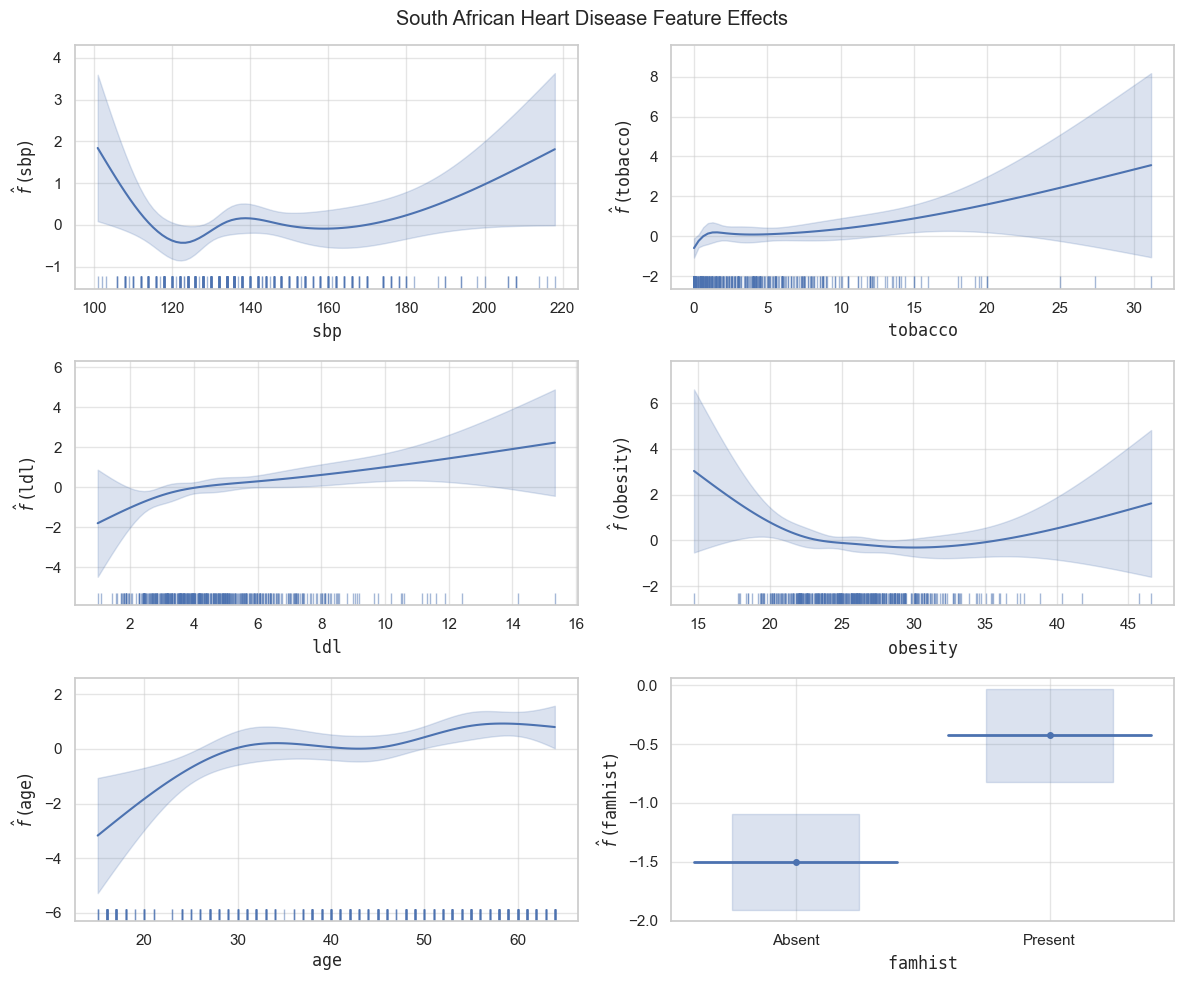

In [56]:
feature_types = {
    "sbp": "numerical",
    "tobacco": "numerical",
    "ldl": "numerical",
    "obesity": "numerical",
    "age": "numerical",
    "famhist": "categorical",
}
heart_disease_model = HeartDiseaseModel(heart_data, feature_types)
heart_disease_model.fit()
heart_disease_model.plot_all_feature_effects();

Some comments on the implementation:
- The $y$-values above are different from the book but are essentially arbitrary - differences can be absorbed by the intercept term.
- Fitting the model is exactly the same as the linear regression examples above, just using `LogisticRegression` instead.
- To faithfully reproduce what's in the book I needed to set to knots manually as the default selection in patsy removes duplicates among the x-values. This is has advantages - trying to fit the model with more degrees of freedom fails because you get duplicate knots.
- `patsy` makes it easy to define the $\hat{f}_j$, using `X.design_info.subset(formula)` to get a subdesign matrix for a single feature and `design_info.slice(feature_formula)` to get the slice object for indices.
- The fact that `patsy` automatically adjusts the encoding categorical variables to enforce full rank if you remove the intercept from the formula is quite annoying. It means that I couldn't choose to have the intercept term added in the regression itself.